# Load in relevant libraries

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Reading/ Preprocess Data and Undersampling

In [2]:
data = pd.read_csv('Family1.csv')
data.head()

,Unnamed: 0,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,...,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Threat_Binary,Threat
0,0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,...,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0,0
1,1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,...,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,0,0
2,2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,...,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,0,0
3,3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,...,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,0,0
4,4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,...,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0,0


In [3]:
# Separate majority and minority classes
majority_class = data[data['Threat_Binary'] == 1]
minority_class = data[data['Threat_Binary'] == 0]

# Determine the number of samples to keep from the majority class
undersample_size = len(minority_class)

# Randomly select samples from the majority class
undersampled_majority = majority_class.sample(n=undersample_size, random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_data = pd.concat([undersampled_majority, minority_class])

# Shuffle the dataset to mix up the samples
undersampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)
y = undersampled_data['Threat_Binary']
#y = y.apply(lambda x: 1 if x ==0 else 0)
x = undersampled_data.copy(deep = True).drop(['Threat','Threat_Binary'],axis = 1)
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_scaled = scaler.fit_transform(x)

# Gradient Boosting 50 Learners

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert the data into TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test,dtype = tf.float32)

# Define the gradient boosting model parameters
learning_rate = 0.1
n_estimators = 50

# Define TensorFlow decision trees
trees = []

# List to store loss history for plotting
loss_history = []

# Initialize an empty tensor to accumulate predictions
y_preds_sum = tf.zeros_like(y_test_tensor)

for _ in range(n_estimators):
    tree = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    tree.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                 loss='binary_crossentropy')
    trees.append(tree)

# Train the model
for tree in trees:
    history = tree.fit(X_train_tensor, y_train_tensor, epochs=1, batch_size=32, verbose=0)
    loss_history.append(history.history['loss'][0])
    y_preds_sum += tree.predict(X_test_tensor)

# Average the predictions across all trees
y_pred_avg = y_preds_sum / n_estimators
y_pred = tf.round(y_pred_avg).numpy().flatten()




620/620 [==============================] - 1s 1ms/step


# Ploting Visualisations

In [6]:
consensus_prediction = np.mean(y_pred_avg, axis=1)

# Round the consensus predictions to get the final binary predictions
y_pred_fin = np.round(consensus_prediction).astype(int)
print(classification_report(y_test, y_pred_fin))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      9870
           1       0.64      0.59      0.61      9950

    accuracy                           0.63     19820
   macro avg       0.63      0.63      0.63     19820
weighted avg       0.63      0.63      0.63     19820



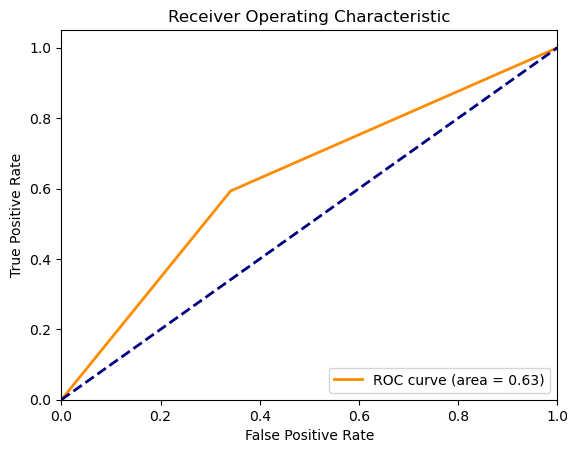

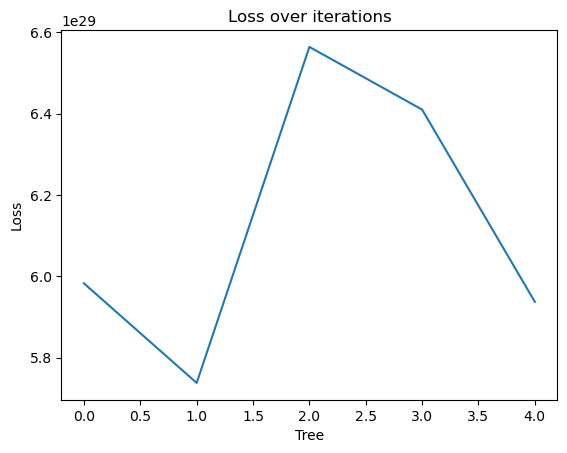

Accuracy: 0.625832492431887


In [7]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_fin)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the loss history
plt.plot(loss_history)
plt.title('Loss over iterations')
plt.xlabel('Tree')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_fin)
print("Accuracy:", accuracy)

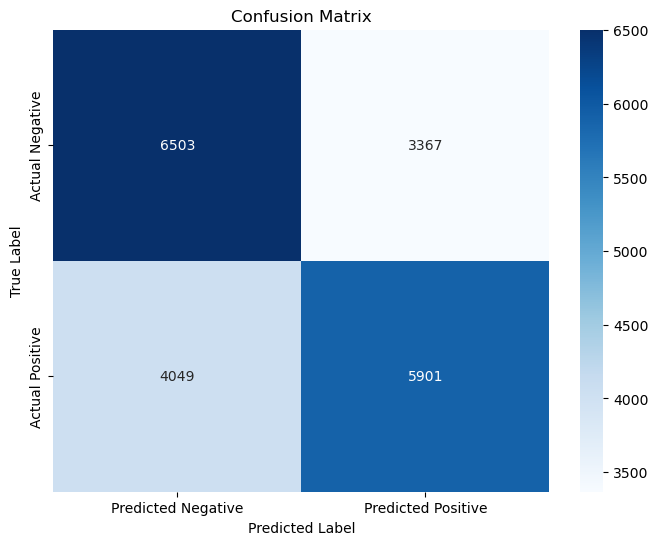

In [10]:
cm = confusion_matrix(y_test, y_pred_fin)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()